# Welcome to Population Projection!!

This notebook will help you build a feel for what our population projection modeling can do for you. To use it, go down the notebook editing the user inputs (**Look for the #USER INPUTS header!**) in each cell to play with the results. To run a cell, select it and hit the "Run" button (or hit Shift+Enter on your keyboard). Each time you open this notebook, you should run the "Setup" section exactly once, then you may skip forward and run whatever cell/section you'd like, as long as you run the first cell in a section before the rest.

FYI, most of the cells will take 20-60s to run. You tell a cell is still running if it has a (*) next to it.

As a preface, here are some high level Pros / Cons:

### Pros:
* Can be arbitrarily lightweight. At its most basic, this model can be run with two numbers: the average prison admissions and the average prison LOS. In the other extreme, it can also be run with DSA data to produce a pretty robust population projection. The key point is that in either case the work is mostly done before you start.
* Dynamically captures inter-relatedness of different parts of the Justice System (e.g. modeling sentence reductions will cause an increase in revocations from having more people released earlier).
* Captures order-of-magnitude "back-of-the-napkin" effects robustly and super, super efficiently (e.g. If we abolish mandatory minimums in our state, what will the ballpark population reduction be?)

### Cons:
* Limit to the accuracy of policy simulation. As you'll discover below, the model uses a set of simple parameters to define the policy effects. Often, those parameters have to be guesstimated. The uncertainty associated with these parameters is what makes it difficult to get past a ballpark estimate.
* Cannot capture some second order effects. For example, the question of how early release will affect the revocatino rate (e.g. whether people will commit more crime if they're released early vs. serve a full sentence) is difficult to incorporate into a policy projection.



# Setup

In [1]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../../../..')) 



In [23]:
from recidiviz.calculator.modeling.population_projection.simulations.super_simulation.super_simulation_factory import SuperSimulationFactory
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
from recidiviz.calculator.modeling.population_projection.simulations.transition_table import TransitionTable
from recidiviz.calculator.modeling.population_projection.utils.transitions_utils import TransitionTableType
from functools import partial
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config Completer.use_jedi = False

#Built this notebook with ID, but it's easy to adapt to ND so ping Paco if you're interested.
test_sim = SuperSimulationFactory.build_super_simulation('../microsimulations/us_id_model_inputs.yaml')

/Users/pacopoler/.local/share/virtualenvs/pulse-data-Jd9N3JcA/lib/python3.7/site-packages/google/cloud/bigquery/table.py:1770: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  create_bqstorage_client=create_bqstorage_client,


outflows_data for population_outflows returned 97221 results
transitions_data for population_transitions_materialized returned 222750 results
total_population_data for total_population returned 264611 results
remaining_sentence_data for remaining_sentences_materialized returned 574867 results
excluded_population_data for us_id_excluded_population returned 120865 results


# Analyzing Baseline Dynamics

This simulation has nine "compartments," two "shell" compartments that feed new people into the system and seven "full" compartments which contain people as they move through the system.

* PRETRIAL (shell): This is where new people enter the justice system who have never been justice-involved before.
* RELEASE (shell): This is where people re-enter the justice system who have been justice-involved, then fully released.
* INCARCERATION - TREATMENT_IN_PRISON (full): incarcerated people participating in a treatment program.
* INCARCERATION - PAROLE_BOARD_HOLD (full): incarcerated people who are either recently revoked from parole or about to be released to parole. Typically short stays followed by release or transition to proper incarceration.
* INCARCERATION - GENERAL (full): incarcerated people who are not in any of the above INCARCERATION compartments and are in prison for the first time.
* INCARCERATION - GENERAL (full): incarcerated people who are not in any of the above INCARCERATION compartments and are in prison for the second or subsequent time.
* SUPERVISION - PAROLE (full): people on parole supervision
* SUPERVISION - PROBATION (full): people on probation supervision
* RELEASE - RELEASE (full): people fully released from the justice system (Note: this simulation makes a simplifying assumption that makes it appear as though no people recidivate from this compartment. Ping Paco if you're interested in understanding this piece further).

The simplest thing you can do with the population projection model is run a baseline, which is to say a vanilla projection of the current population forward. In the next cell, you'll run that simulation.

../../../../../recidiviz/calculator/modeling/population_projection/simulations/super_simulation/initializer.py:192: UserWarning: Outflows data is missing for more than 25.0% for some disaggregations:
gender  compartment  outflow_to             
FEMALE  RELEASE      INCARCERATION - GENERAL    60.185185
                     SUPERVISION - PAROLE       89.814815
MALE    RELEASE      SUPERVISION - PAROLE       49.074074
dtype: float64
  f"Outflows data is missing for more than {missing_event_threshold * 100}% for some disaggregations:\n"
../../../../../recidiviz/calculator/modeling/population_projection/simulations/sub_simulation/sub_simulation_factory.py:139: Warning: Some transitions data not fed to a compartment:      state_code   run_date                       compartment  \
16        US_ID 2021-01-01  SUPERVISION - INFORMAL_PROBATION   
17        US_ID 2021-01-01    SUPERVISION - INTERNAL_UNKNOWN   
21        US_ID 2021-01-01  SUPERVISION - INFORMAL_PROBATION   
22        US_ID 2021-01

initialization time:  8.999168872833252
simulation_time:  24.16806697845459


../../../../../recidiviz/calculator/modeling/population_projection/simulations/sub_simulation/sub_simulation_factory.py:139: Warning: Some transitions data not fed to a compartment:      state_code   run_date                       compartment  \
16        US_ID 2021-01-01  SUPERVISION - INFORMAL_PROBATION   
17        US_ID 2021-01-01    SUPERVISION - INTERNAL_UNKNOWN   
21        US_ID 2021-01-01  SUPERVISION - INFORMAL_PROBATION   
22        US_ID 2021-01-01  SUPERVISION - INFORMAL_PROBATION   
27        US_ID 2021-01-01  SUPERVISION - INFORMAL_PROBATION   
...         ...        ...                               ...   
9312      US_ID 2021-01-01    SUPERVISION - INTERNAL_UNKNOWN   
9325      US_ID 2021-01-01    SUPERVISION - INTERNAL_UNKNOWN   
9326      US_ID 2021-01-01  SUPERVISION - INFORMAL_PROBATION   
9328      US_ID 2021-01-01  SUPERVISION - INFORMAL_PROBATION   
9337      US_ID 2021-01-01    SUPERVISION - INTERNAL_UNKNOWN   

                               outflow_to  compar

initialization time:  9.689931869506836
simulation_time:  24.457065105438232


../../../../../recidiviz/calculator/modeling/population_projection/simulations/sub_simulation/sub_simulation_factory.py:139: Warning: Some transitions data not fed to a compartment:      state_code   run_date                       compartment  \
16        US_ID 2021-01-01  SUPERVISION - INFORMAL_PROBATION   
17        US_ID 2021-01-01    SUPERVISION - INTERNAL_UNKNOWN   
21        US_ID 2021-01-01  SUPERVISION - INFORMAL_PROBATION   
22        US_ID 2021-01-01  SUPERVISION - INFORMAL_PROBATION   
27        US_ID 2021-01-01  SUPERVISION - INFORMAL_PROBATION   
...         ...        ...                               ...   
9312      US_ID 2021-01-01    SUPERVISION - INTERNAL_UNKNOWN   
9325      US_ID 2021-01-01    SUPERVISION - INTERNAL_UNKNOWN   
9326      US_ID 2021-01-01  SUPERVISION - INFORMAL_PROBATION   
9328      US_ID 2021-01-01  SUPERVISION - INFORMAL_PROBATION   
9337      US_ID 2021-01-01    SUPERVISION - INTERNAL_UNKNOWN   

                               outflow_to  compar

initialization time:  8.967859983444214
simulation_time:  24.107065200805664


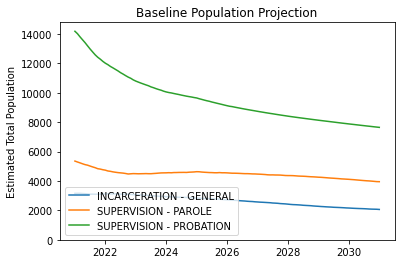

In [24]:
# USER_INPUTS
# fill in list with whichever full compartments' populations you would like to see at the end of the simulation
DISPLAY_COMPARTMENTS = ['INCARCERATION - GENERAL', 'SUPERVISION - PAROLE', 'SUPERVISION - PROBATION']

######################################################################################################################

test_sim.simulate_baseline(DISPLAY_COMPARTMENTS)

### LOS distributions
The population projection model makes it really easy to ascertain how long people are staying in different places and where they're going next. In the next cell, you'll see the cumulative probability distribution (cdf) for the compartment of your choice. This graph measures the total fraction of a cohort has left to different places over time.

LOS distribution stats:


count    4272.000000
mean       19.504682
std        18.094641
min         1.000000
25%         6.000000
50%        14.000000
75%        28.000000
max       104.000000
Name: compartment_duration, dtype: float64

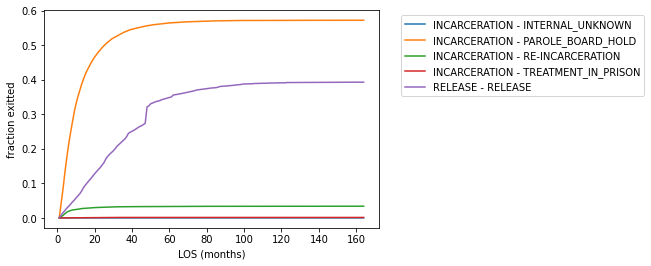

In [25]:
# USER INPUTS (heads up that this one takes a good while to run)
# Pick a compartment to analyze, then optionally replace the `None` with a list of outflow compartments
#    you want to see. If you leave it as None it'll just show all of them.
GENDER = 'MALE'
MAX_LOS_TO_DISPLAY = 240 # this is in months
ANALYSIS_COMPARTMENT = 'SUPERVISION - PAROLE'
OUTFLOWS_OF_INTEREST = None

######################################################################################################################

transition_table = test_sim.simulator.pop_simulations['baseline_middle'].sub_simulations[GENDER]\
    .simulation_compartments[ANALYSIS_COMPARTMENT].compartment_transitions.transition_tables[1]

transition_table.unnormalize_table(state=TransitionTableType.AFTER)

transitions = transition_table.transition_dfs[TransitionTableType.AFTER]

outflows = OUTFLOWS_OF_INTEREST or transitions.columns
transitions[outflows].cumsum().iloc[:MAX_LOS_TO_DISPLAY].plot(xlabel='LOS (months)', ylabel='fraction exitted')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

transition_table._normalize_table(TransitionTableType.AFTER)

print("LOS distribution stats:")
hist_data = test_sim.simulator.pop_simulations['baseline_middle'].sub_simulations[GENDER]\
    .simulation_compartments[ANALYSIS_COMPARTMENT].compartment_transitions.historical_outflows

disg_data = pd.DataFrame()
for _, row in hist_data.iterrows():
    for i in range(int(row.total_population)):
        disg_data = disg_data.append(row)

disg_data.compartment_duration.describe()

### Comparing across sub-groups
Another analysis that's easy to play with using the population projection model is cross-group comparisons. In this case, we can only compare across gender, but it's very common to compare across different crimes, ages, races in other population projections (including policies that affect different groups differently, by the way). In the next cell, pick a specific flow between two compartments to compare between genders.

1.0
0.9945054945054945
0.989010989010989
0.9835164835164835
0.978021978021978
0.9725274725274725
0.967032967032967
0.9615384615384616
0.9560439560439561
0.9505494505494505
0.945054945054945
0.9395604395604396
0.9340659340659341
0.9285714285714286
0.9230769230769231
0.9175824175824175
0.9120879120879121
0.9065934065934066
0.9010989010989011
0.8956043956043956
0.8901098901098901
0.8846153846153846
0.8791208791208791
0.8736263736263736
0.8681318681318682
0.8626373626373627
0.8571428571428571
0.8516483516483516
0.8461538461538461
0.8406593406593407
0.8351648351648352
0.8296703296703297
0.8241758241758241
0.8186813186813187
0.8131868131868132
0.8076923076923077
0.8021978021978022
0.7967032967032966
0.7912087912087912
0.7857142857142857
0.7802197802197802
0.7747252747252747
0.7692307692307693
0.7637362637362637
0.7582417582417582
0.7527472527472527
0.7472527472527473
0.7417582417582418
0.7362637362637363
0.7307692307692307
0.7252747252747253
0.7197802197802198
0.7142857142857143
0.7087912087

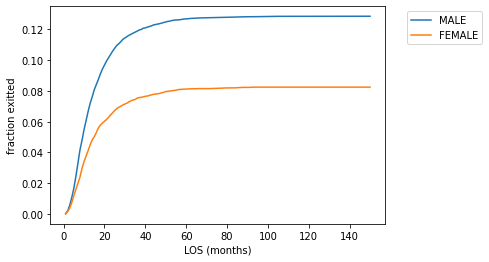

In [24]:
# USER INPUTS (heads up that this one takes a good while to run)
# Pick an `leaving from` and `arriving at` compartment to define the start and endpoint of 
#     the flow you're interested in visualizing.
MAX_LOS_TO_DISPLAY = 150 # this is in months
LEAVING_FROM = 'SUPERVISION - PROBATION'
ARRIVING_AT = 'INCARCERATION - RE-INCARCERATION'

######################################################################################################################

transition_table_male = test_sim.simulator.pop_simulations['baseline_middle'].sub_simulations['MALE']\
    .simulation_compartments[LEAVING_FROM].compartment_transitions.transition_tables[1]

transition_table_male.unnormalize_table(state=TransitionTableType.AFTER)

transition_table_female = test_sim.simulator.pop_simulations['baseline_middle'].sub_simulations['FEMALE']\
    .simulation_compartments[LEAVING_FROM].compartment_transitions.transition_tables[1]

transition_table_female.unnormalize_table(state=TransitionTableType.AFTER)

transitions = pd.DataFrame()
transitions['MALE'] = transition_table_male.transition_dfs[TransitionTableType.AFTER][ARRIVING_AT]
transitions['FEMALE'] = transition_table_female.transition_dfs[TransitionTableType.AFTER][ARRIVING_AT]

transitions.cumsum().iloc[:MAX_LOS_TO_DISPLAY].plot(xlabel='LOS (months)', ylabel='fraction exitted')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

transition_table_male._normalize_table(TransitionTableType.AFTER)
transition_table_female._normalize_table(TransitionTableType.AFTER)

### Historical admissions
There's lots more tinkering one can do with just a baseline, but the last thing we'll show here is how to peek at the historical trend in admissions.

[<AxesSubplot:title={'center':'compartment: PRETRIAL\noutflow_to: INCARCERATION - GENERAL'}, xlabel='time_step'>,
 <AxesSubplot:title={'center':'compartment: PRETRIAL\noutflow_to: INCARCERATION - TREATMENT_IN_PRISON'}, xlabel='time_step'>,
 <AxesSubplot:title={'center':'compartment: PRETRIAL\noutflow_to: SUPERVISION - PROBATION'}, xlabel='time_step'>,
 <AxesSubplot:title={'center':'compartment: RELEASE\noutflow_to: INCARCERATION - GENERAL'}, xlabel='time_step'>,
 <AxesSubplot:title={'center':'compartment: RELEASE\noutflow_to: INCARCERATION - RE-INCARCERATION'}, xlabel='time_step'>,
 <AxesSubplot:title={'center':'compartment: RELEASE\noutflow_to: INCARCERATION - TREATMENT_IN_PRISON'}, xlabel='time_step'>,
 <AxesSubplot:title={'center':'compartment: RELEASE\noutflow_to: SUPERVISION - PAROLE'}, xlabel='time_step'>,
 <AxesSubplot:title={'center':'compartment: RELEASE\noutflow_to: SUPERVISION - PROBATION'}, xlabel='time_step'>]

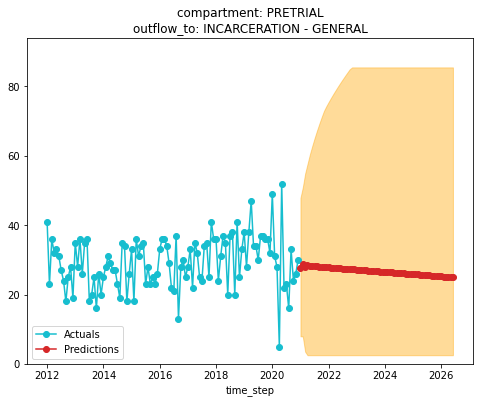

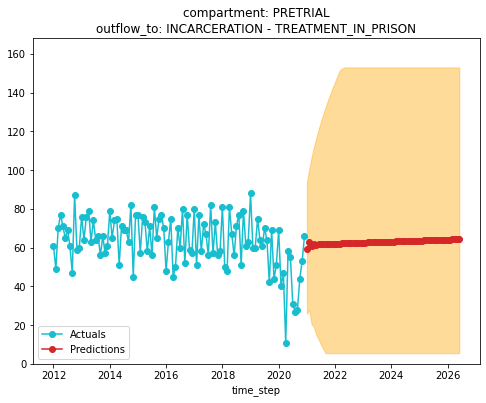

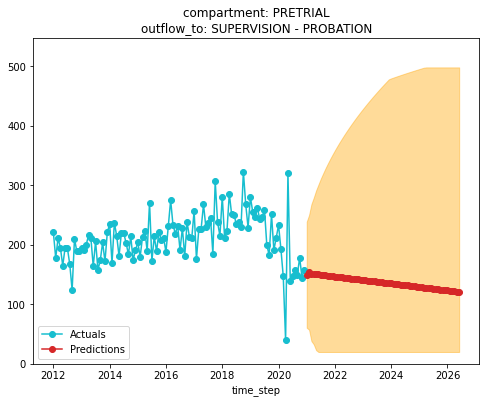

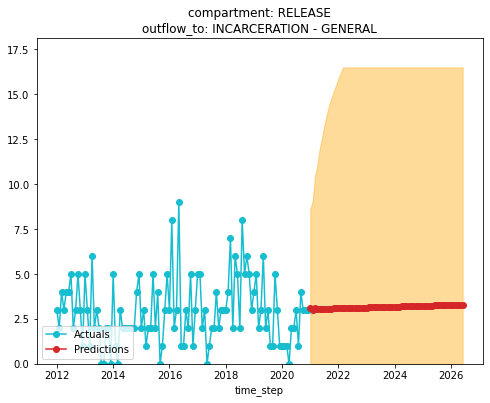

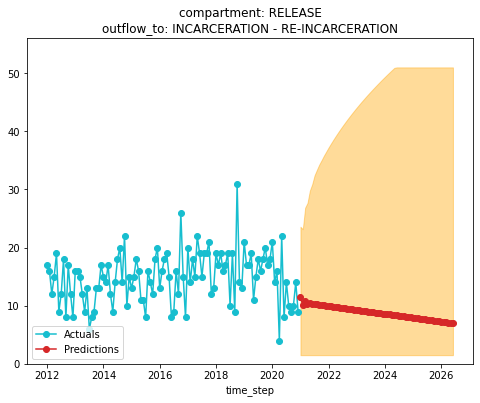

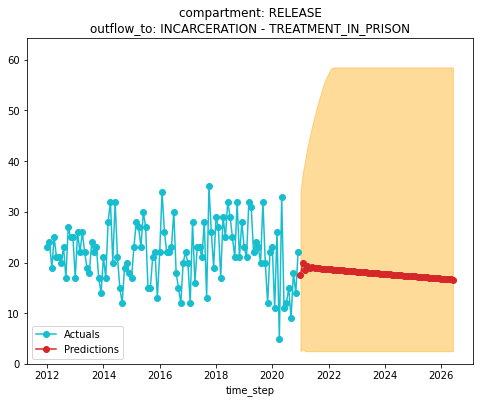

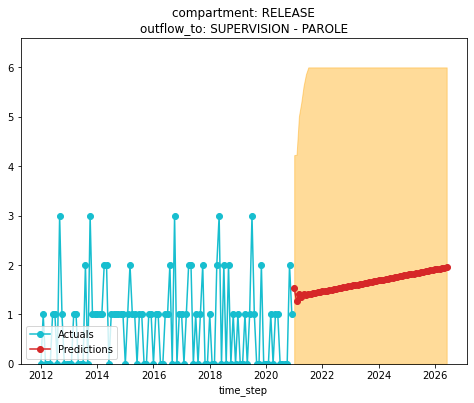

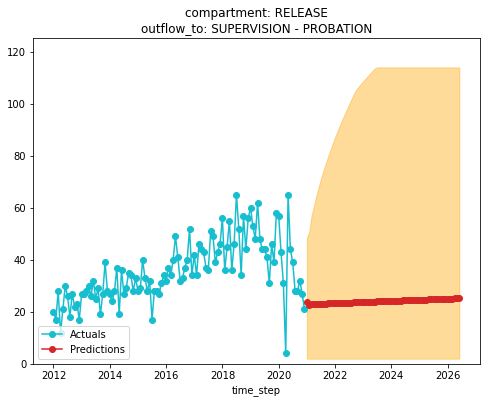

In [25]:
# USER INPUTS
# Pick whether to display trends by gender or in aggregate
DISAGGREGATE_BY_GENDER=False

######################################################################################################################

test_sim.get_arima_output_plots('baseline_middle', by_simulation_group=DISAGGREGATE_BY_GENDER)


# Understanding Drivers of Incarceration Through Policy Modeling

In this section you can use policy simulations to test out what could happen in different scenarios. As you'll see, the process of layering policies over a baseline requires very minimal additional work, which makes it easy to play around and experiment. **The person who finds the path of leastest resistance to acheive Recidiviz's 5-year goal of 20% prison reduction will win...a personalized poetry anthology from Paco !!!**

The simulation compartments are the same as above.

../../../../../recidiviz/calculator/modeling/population_projection/simulations/super_simulation/initializer.py:192: UserWarning: Outflows data is missing for more than 25.0% for some disaggregations:
gender  compartment  outflow_to             
FEMALE  RELEASE      INCARCERATION - GENERAL    60.185185
                     SUPERVISION - PAROLE       89.814815
MALE    RELEASE      SUPERVISION - PAROLE       49.074074
dtype: float64
  f"Outflows data is missing for more than {missing_event_threshold * 100}% for some disaggregations:\n"
../../../../../recidiviz/calculator/modeling/population_projection/simulations/sub_simulation/sub_simulation_factory.py:139: Warning: Some transitions data not fed to a compartment:      state_code   run_date                       compartment  \
16        US_ID 2021-01-01  SUPERVISION - INFORMAL_PROBATION   
17        US_ID 2021-01-01    SUPERVISION - INTERNAL_UNKNOWN   
21        US_ID 2021-01-01  SUPERVISION - INFORMAL_PROBATION   
22        US_ID 2021-01

initialization time:  11.378232717514038


../../../../../recidiviz/calculator/modeling/population_projection/simulations/sub_simulation/sub_simulation_factory.py:139: Warning: Some transitions data not fed to a compartment:      state_code   run_date                       compartment  \
16        US_ID 2021-01-01  SUPERVISION - INFORMAL_PROBATION   
17        US_ID 2021-01-01    SUPERVISION - INTERNAL_UNKNOWN   
21        US_ID 2021-01-01  SUPERVISION - INFORMAL_PROBATION   
22        US_ID 2021-01-01  SUPERVISION - INFORMAL_PROBATION   
27        US_ID 2021-01-01  SUPERVISION - INFORMAL_PROBATION   
...         ...        ...                               ...   
9312      US_ID 2021-01-01    SUPERVISION - INTERNAL_UNKNOWN   
9325      US_ID 2021-01-01    SUPERVISION - INTERNAL_UNKNOWN   
9326      US_ID 2021-01-01  SUPERVISION - INFORMAL_PROBATION   
9328      US_ID 2021-01-01  SUPERVISION - INFORMAL_PROBATION   
9337      US_ID 2021-01-01    SUPERVISION - INTERNAL_UNKNOWN   

                               outflow_to  compar

initialization time:  9.251675128936768
simulation_time:  24.964940071105957
simulation_time:  24.766573905944824


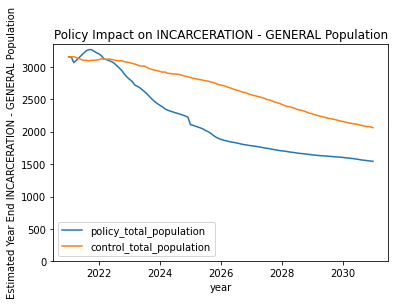

In [26]:
# USER INPUTS
# Below are two example policies demonstrating some of the diferent kinds of changes you can make with
#      a policy function. In addition to changing these, you're encouraged to make copies and try even more 
#      combinations including applying the same policy to multiple compartments.
# In addition to setting the user inputs dictionary values in this section, you'll also have to go change the 
#     `policy_list` (see the comment toward the bottom of this cell for that).

# percentage LOS reduction policy architype
# Spark example use: abolishing truth-in-sentencing
LOS_REDUCTION_INPUTS = {
    'REDUCTION_SIZE': 0.20, # By what amount should LOS be shortened
    'AFFECTED_FRACTION': 0.5, # What fraction of people should have their LOS shortened
    'REDUCTION_TYPE': '*', # If `*` then reduce multiplicatively (i.e. x -> (1 - 0.2) x), if '+' then reduce addatively (e.g. x -> x - 0.2)
    'AFFECTED_COMPARTMENT': 'INCARCERATION - GENERAL', # Compartment on whose transitions to apply the policy
    'AFFECTED_OUTFLOW': 'SUPERVISION - PAROLE', # Destination compartment for the flow to be affected by the policy
    'RETROACTIVE': False # Boolean indicating whether or not to apply the policy retroactively
}


# reallocate a flow between compartments
# Spark example use: financial incentives for parole offices to reduce technical revocations
REALLOCATION_INPUTS = {
    'AFFECTED_FRACTION': 0.5, # What fraction of people should be moved
    'REDUCTION_TYPE': '+', # A little complicated, ping Paco (or try it for yourself!) if you want to change the default
    'AFFECTED_COMPARTMENT': 'SUPERVISION - PAROLE', # Compartment on whose transitions to apply the policy
    'ORIGINAL_OUTFLOW': 'INCARCERATION - PAROLE_BOARD_HOLD', # Original destination you wish to siphon from
    'NEW_OUTFLOW': 'RELEASE - RELEASE', # New destination compartment
    'RETROACTIVE': False # Boolean indicating whether or not to apply the policy retroactively
}
######################################################################################################################


def LOS_reduction(inputs_dict):
    return partial(TransitionTable.apply_reduction, 
                   reduction_df=pd.DataFrame({
                       'outflow':[inputs_dict['AFFECTED_OUTFLOW']],
                       'affected_fraction': [inputs_dict['AFFECTED_FRACTION']],
                       'reduction_size': [inputs_dict['REDUCTION_SIZE']]
                   }),
                   reduction_type=inputs_dict['REDUCTION_TYPE'],
                   retroactive=inputs_dict['RETROACTIVE'])

def reallocation(inputs_dict):
    return partial(TransitionTable.reallocate_outflow, 
                   reallocation_df=pd.DataFrame({
                       'outflow':[inputs_dict['ORIGINAL_OUTFLOW']],
                       'affected_fraction': [inputs_dict['AFFECTED_FRACTION']],
                       'new_outflow': [inputs_dict['NEW_OUTFLOW']]
                   }),
                   reallocation_type=inputs_dict['REDUCTION_TYPE'],
                   retroactive=inputs_dict['RETROACTIVE'])

def get_spark_policies(policy_function, user_inputs):
    return [
        SparkPolicy(policy_fn=policy_function(user_inputs),
            spark_compartment=user_inputs['AFFECTED_COMPARTMENT'],
            sub_population={'gender': gender},
            policy_ts=2,
            apply_retroactive=user_inputs['RETROACTIVE'])
        for gender in ['MALE', 'FEMALE']
    ]
        

######################################################################################################################
# USER INPUTS PART 2
# In the first input, put in a `get_spark_policies` with the user inputs and corresponding 
#     policy function for each policy you want to model
# In the second input, choose a compartment to visualize the resuls for


test_results = test_sim.simulate_policy(
    get_spark_policies(LOS_reduction, LOS_REDUCTION_INPUTS),
    'INCARCERATION - GENERAL'
)



### More visualizations of the policy simulation
You can use these cells to visualize different details of a policy scenario you ran above. As an aside, the compartment you chose to visualize above doesn't affect anything besides the graph at the end, so you don't have to rerun the whole simulation with a different compartment in there.

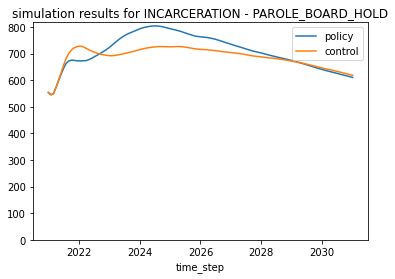

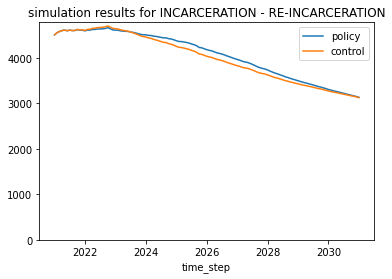

In [27]:
# USER INPUTS -- visualizing multiple compartments of a simulation.
# Pick which compartments you want to look at
DISPLAY_COMPARTMENTS=['INCARCERATION - PAROLE_BOARD_HOLD', 'INCARCERATION - RE-INCARCERATION']

######################################################################################################################

policy_populations = test_sim.simulator.pop_simulations['policy'].population_projections
policy_populations = [policy_populations[policy_populations.compartment == i] for i in DISPLAY_COMPARTMENTS]

control_populations = test_sim.simulator.pop_simulations['control'].population_projections
control_populations = [control_populations[control_populations.compartment == i] for i in DISPLAY_COMPARTMENTS]

reference_year = test_sim.initializer.get_reference_year()
time_step = test_sim.initializer.get_time_step()

for compartment_idx, compartment in enumerate(DISPLAY_COMPARTMENTS):
    display_df = pd.DataFrame()
    display_df['policy'] = policy_populations[compartment_idx].groupby('time_step').sum().total_population
    display_df['control'] = control_populations[compartment_idx].groupby('time_step').sum().total_population
    display_df.index = test_sim.initializer.convert_to_absolute_year(time_step, reference_year, pd.Series(display_df.index))
    display_df.plot(title=f'simulation results for {compartment}', ylim=[0, None])



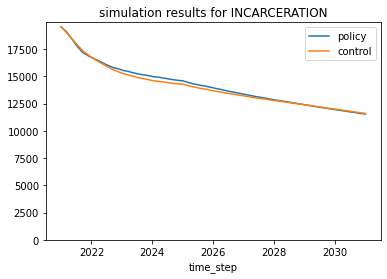

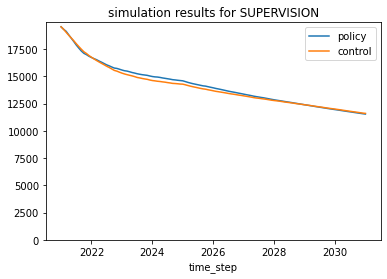

In [28]:
# USER INPUTS -- Total incarcerated and supervised populations
# The default groups together the incarceration and supervision compartments, but feel free to change the 
#     grouping however you want!

INCARCERATION_COMPARTMENTS = ['INCARCERATION - PAROLE_BOARD_HOLD', 'INCARCERATION - GENERAL', 
                             'INCARCERATION - RE-INCARCERATION', 'INCARCERATION - TREATMENT_IN_PRISON']
SUPERVISION_COMPARTMENTS = ['SUPERVISION - PAROLE', 'SUPERVISION - PROBATION']

######################################################################################################################


policy_populations = test_sim.simulator.pop_simulations['policy'].population_projections
policy_populations = [policy_populations[policy_populations.compartment.apply(lambda x: x in INCARCERATION_COMPARTMENTS)],
                      policy_populations[policy_populations.compartment.apply(lambda x: x in SUPERVISION_COMPARTMENTS)],]

control_populations = test_sim.simulator.pop_simulations['control'].population_projections
control_populations = [control_populations[control_populations.compartment.apply(lambda x: x in INCARCERATION_COMPARTMENTS)],
                      control_populations[control_populations.compartment.apply(lambda x: x in SUPERVISION_COMPARTMENTS)],]

reference_year = test_sim.initializer.get_reference_year()
time_step = test_sim.initializer.get_time_step()

for group_idx, group in enumerate(['INCARCERATION', 'SUPERVISION']):
    display_df = pd.DataFrame()
    display_df['policy'] = policy_populations[compartment_idx].groupby('time_step').sum().total_population
    display_df['control'] = control_populations[compartment_idx].groupby('time_step').sum().total_population
    display_df.index = test_sim.initializer.convert_to_absolute_year(time_step, reference_year, pd.Series(display_df.index))
    display_df.plot(title=f'simulation results for {group}', ylim=[0, None])





Did that set gears turning in your head? Do you have ideas for extensions, use-cases, or demos? Ping Paco! He's budgetted time this week for exactly that!